# Computer Vision Face Detection Lab - Student Notebook



## Importing Python packages

Start by importing the Python packages that you need.

In the following code:

- *matplotlib* provides plotting functions
- *skimage* represents scikit-image, which provides several useful image manipulation tools
- *boto3* represents the AWS SDK for Python (Boto3), which is the Python library for AWS
- *numpy* represents NumPy, which is a library for manipulating data
- *PIL* represents the Python Imaging Library, which contains a set of tools for drawing images


In [29]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt

import boto3

import numpy as np

from PIL import Image, ImageDraw, ImageColor, ImageOps


## Task 1: Creating a collection


In [30]:
client = boto3.client('rekognition')
collection_id = 'Collection'
try:
    response = client.create_collection(CollectionId=collection_id)
    print('Collection ARN: ' + response['CollectionArn'])
    print('Status Code:' + str(response['StatusCode']))
    print('Done...')
except client.exceptions.ResourceAlreadyExistsException:
    print('Collection already exists')


Collection ARN: aws:rekognition:us-east-1:889168382802:collection/Collection
Status Code:200
Done...


## Task 2: Uploading an image to search

Use the provided sample image, which is named *mum.jpg*, and upload it to this notebook.


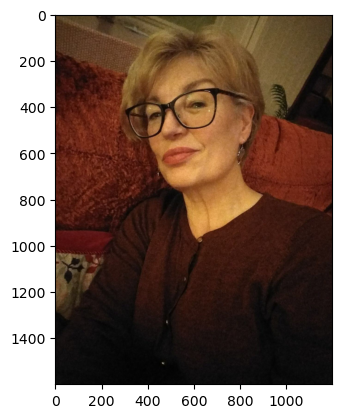

In [31]:

# Task 2: Uploading an image to search
filename = "mum.jpg"
faceimage = io.imread(filename)
plt.imshow(faceimage)
plt.show()


## Task 3: Adding the image to the collection


In [32]:
externalimageid = filename

with open(filename, 'rb') as fimage:
    response = client.index_faces(CollectionId = collection_id,
                             Image={'Bytes': fimage.read()},
                             ExternalImageId=externalimageid,
                             MaxFaces=1,
                             QualityFilter="AUTO",
                             DetectionAttributes=['ALL'])

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
     print('  Face ID: ' + faceRecord['Face']['FaceId'])
     print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

print('Faces not indexed:')
for unindexedFace in response['UnindexedFaces']:
    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
    print(' Reasons:')
    for reason in unindexedFace['Reasons']:
        print('   ' + reason)

Results for mum.jpg
Faces indexed:
  Face ID: 26e5bd33-8f5c-42ac-877b-f0b619a65c48
  Location: {'Width': 0.3475711941719055, 'Height': 0.35248002409935, 'Left': 0.3103867471218109, 'Top': 0.11069528758525848}
Faces not indexed:


## Task 4: Viewing the bounding box for the detected face


In [33]:
# Rescale the image if it's larger than 4096 x 4096 pixels
max_size = 4096
if max(faceimage.shape) > max_size:
    scale_factor = max_size / max(faceimage.shape)
    faceimage = rescale(faceimage, scale_factor, mode='constant')

io.imsave(filename, faceimage)

with open(filename, 'rb') as fimage:
    response = client.index_faces(
        CollectionId=collection_id,
        Image={'Bytes': fimage.read()},
        ExternalImageId=externalimageid,
        MaxFaces=1,
        QualityFilter="AUTO",
        DetectionAttributes=['ALL']
    )

print('Results for ' + filename)
print('Faces indexed:')
for faceRecord in response['FaceRecords']:
    print('  Face ID: ' + faceRecord['Face']['FaceId'])
    print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))


Results for mum.jpg
Faces indexed:
  Face ID: 1a8e5a1f-e35b-425d-966b-7dbd3fcb859e
  Location: {'Width': 0.3475711941719055, 'Height': 0.35248002409935, 'Left': 0.3103867471218109, 'Top': 0.11069528758525848}


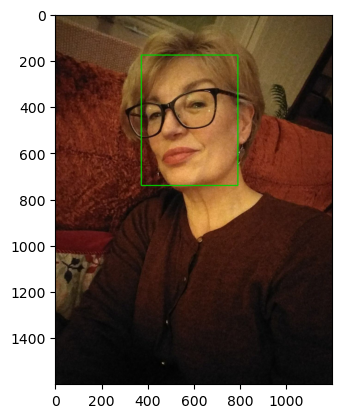

In [34]:
# Task 4: Viewing the bounding box for the detected face
img = Image.open(filename)
imgWidth, imgHeight = img.size

draw = ImageDraw.Draw(img)
for faceRecord in response['FaceRecords']:
    box = faceRecord['Face']['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left, top), (left + width, top), (left + width, top + height),
              (left, top + height), (left, top))

    draw.line(points, fill='#00d400', width=5)

plt.imshow(img)
plt.show()


In [35]:

# Task 5: Listing faces in the collection
maxResults = 2
faces_count = 0
tokens = True

response = client.list_faces(CollectionId=collection_id, MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:
    faces = response['Faces']

    for face in faces:
        print(face)
        faces_count += 1

    if 'NextToken' in response:
        nextToken = response['NextToken']
        response = client.list_faces(CollectionId=collection_id, NextToken=nextToken, MaxResults=maxResults)
    else:
        tokens = False


Faces in collection Collection
{'FaceId': '1a8e5a1f-e35b-425d-966b-7dbd3fcb859e', 'BoundingBox': {'Width': 0.3475709855556488, 'Height': 0.3524799942970276, 'Left': 0.31038698554039, 'Top': 0.1106949970126152}, 'ImageId': '2557aa2e-d8ac-39c9-9309-c4114ae9ab43', 'ExternalImageId': 'mum.jpg', 'Confidence': 99.99430084228516, 'IndexFacesModelVersion': '6.0'}
{'FaceId': '26e5bd33-8f5c-42ac-877b-f0b619a65c48', 'BoundingBox': {'Width': 0.3475709855556488, 'Height': 0.3524799942970276, 'Left': 0.31038698554039, 'Top': 0.1106949970126152}, 'ImageId': 'f9918aca-38fa-3efb-a75e-2ea45f349556', 'ExternalImageId': 'mum.jpg', 'Confidence': 99.99430084228516, 'IndexFacesModelVersion': '6.0'}


In [36]:
with open(filename, 'rb') as fimage:
    response = client.index_faces(
        CollectionId=collection_id,
        Image={'Bytes': fimage.read()},
        ExternalImageId=externalimageid,
        MaxFaces=1,
        QualityFilter="AUTO",
        DetectionAttributes=['ALL']
    )

    fimage.seek(0)  # Reset the file pointer to the beginning
    response_faces = client.detect_faces(
        Image={'Bytes': fimage.read()},
        Attributes=['ALL']
    )

for faceRecord in response_faces['FaceDetails']:
    emotions = faceRecord['Emotions']
    print('Emotions detected:')
    for emotion in emotions:
        print('  Type: ' + emotion['Type'])
        print('  Confidence: ' + str(emotion['Confidence']))


Emotions detected:
  Type: CALM
  Confidence: 98.23291015625
  Type: SURPRISED
  Confidence: 6.399604797363281
  Type: FEAR
  Confidence: 5.905919551849365
  Type: SAD
  Confidence: 2.227536678314209
  Type: ANGRY
  Confidence: 0.45117998123168945
  Type: CONFUSED
  Confidence: 0.2744162976741791
  Type: DISGUSTED
  Confidence: 0.24315239489078522
  Type: HAPPY
  Confidence: 0.16075463593006134


## Task 5: Listing faces in the collection




In [37]:
maxResults=2
faces_count=0
tokens=True

response=client.list_faces(CollectionId=collection_id,
                           MaxResults=maxResults)

print('Faces in collection ' + collection_id)

while tokens:

    faces=response['Faces']

    for face in faces:
        print (face)
        faces_count+=1
    if 'NextToken' in response:
        nextToken=response['NextToken']
        response=client.list_faces(CollectionId=collection_id,
                                   NextToken=nextToken,MaxResults=maxResults)
    else:
        tokens=False

Faces in collection Collection
{'FaceId': '1a8e5a1f-e35b-425d-966b-7dbd3fcb859e', 'BoundingBox': {'Width': 0.3475709855556488, 'Height': 0.3524799942970276, 'Left': 0.31038698554039, 'Top': 0.1106949970126152}, 'ImageId': '2557aa2e-d8ac-39c9-9309-c4114ae9ab43', 'ExternalImageId': 'mum.jpg', 'Confidence': 99.99430084228516, 'IndexFacesModelVersion': '6.0'}
{'FaceId': '26e5bd33-8f5c-42ac-877b-f0b619a65c48', 'BoundingBox': {'Width': 0.3475709855556488, 'Height': 0.3524799942970276, 'Left': 0.31038698554039, 'Top': 0.1106949970126152}, 'ImageId': 'f9918aca-38fa-3efb-a75e-2ea45f349556', 'ExternalImageId': 'mum.jpg', 'Confidence': 99.99430084228516, 'IndexFacesModelVersion': '6.0'}


## Task 6: Finding a face by using the collection


In [38]:
targetfilename = "target.jpg"
timage = open(targetfilename, 'rb')

response2 = client.search_faces_by_image(
    CollectionId=collection_id,
    Image={'Bytes': timage.read()},
    FaceMatchThreshold=threshold,
    MaxFaces=maxFaces
)


timage.close()

faceMatches = response2['FaceMatches']
print('Matching faces')
for match in faceMatches:
    print('FaceId: ' + match['Face']['FaceId'])
    print('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
    print('ExternalImageId: ' + match['Face']['ExternalImageId'])
    
    emotions = match['Face']['FaceAttributes']['Emotions']
    print('Emotions detected:')
    for emotion in emotions:
        print('  Type: ' + emotion['Type'])
        print('  Confidence: ' + str(emotion['Confidence']))


Matching faces
FaceId: 1a8e5a1f-e35b-425d-966b-7dbd3fcb859e
Similarity: 99.97%
ExternalImageId: mum.jpg


KeyError: 'FaceAttributes'

In [44]:
for match in response['FaceMatches']:
    print('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
    print('ExternalImageId: ' + match['Face']['ExternalImageId'])
    
    if 'FaceAttributes' in match['Face']:
        emotions = match['Face']['FaceAttributes']['Emotions']
        print('Emotions detected:')
        for emotion in emotions:
            print(emotion['Type'] + ': ' + "{:.2f}".format(emotion['Confidence']) + "%")
    else:
        print('No face attributes detected.')


KeyError: 'FaceMatches'

Next, call the `search_faces_by_image` operation and see if you get a match.

In [39]:
threshold = 70
maxFaces=2

with open(targetfilename, 'rb') as timage:        
    response2=client.search_faces_by_image(CollectionId=collection_id,
                            Image={'Bytes': timage.read()},
                            FaceMatchThreshold=threshold,
                            MaxFaces=maxFaces)

faceMatches=response2['FaceMatches']
print ('Matching faces')
for match in faceMatches:
        print ('FaceId:' + match['Face']['FaceId'])
        print ('Similarity: ' + "{:.2f}".format(match['Similarity']) + "%")
        print ('ExternalImageId: ' + match['Face']['ExternalImageId'])
        

Matching faces
FaceId:1a8e5a1f-e35b-425d-966b-7dbd3fcb859e
Similarity: 99.97%
ExternalImageId: mum.jpg
FaceId:26e5bd33-8f5c-42ac-877b-f0b619a65c48
Similarity: 99.97%
ExternalImageId: mum.jpg


## Task 7: Drawing a bounding box around the discovered face



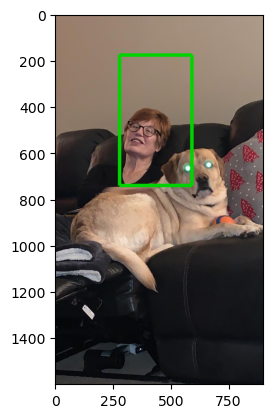

In [42]:
from PIL import Image

# Load the target image
targetimage = Image.open("target.jpg")

imgWidth, imgHeight = targetimage.size

draw = ImageDraw.Draw(targetimage)

for faceMatch in response2['FaceMatches']:
    face = faceMatch['Face']
    box = face['BoundingBox']
    left = imgWidth * box['Left']
    top = imgHeight * box['Top']
    width = imgWidth * box['Width']
    height = imgHeight * box['Height']

    points = ((left, top), (left + width, top), (left + width, top + height),
              (left, top + height), (left, top))

    draw.line(points, fill='#00d400', width=15)

plt.imshow(targetimage)
plt.show()


## Task 8: Deleting the collection



In [43]:
print('Attempting to delete collection ' + collection_id)
status_code=0
try:
    response=client.delete_collection(CollectionId=collection_id)
    status_code=response['StatusCode']
    print('All done!')
    print(status_code)
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ResourceNotFoundException':
        print ('The collection ' + collection_id + ' was not found ')
    else:
        print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
    status_code=e.response['ResponseMetadata']['HTTPStatusCode']



Attempting to delete collection Collection
All done!
200


# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.